In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import shap

In [2]:
df = pd.read_csv("user_log_format1.csv")  # SHA256: a6bc8eabc40b61a562a5e45c91e9b822418d0d863576b28a9ccd549451e55a92
df1 = pd.read_csv("user_info_format1.csv")
df2 = pd.read_csv("train_format1.csv")
# df3 = pd.read_csv("test_format1.csv")
# df3 = df3[df3['user_id'].isin(unique_users)]
# df4 = pd.read_csv("train_format2.csv")
# df4 = df4[df4['user_id'].isin(unique_users)]
# df5 = pd.read_csv("test_format2.csv")
# df5 = df5[df5['user_id'].isin(unique_users)]

#print(df.shape)
#unique_users = df['user_id'].unique()
df = df[df['item_id'].isin(range(481, 640+1))]
#df2 = df2[df2['user_id'].isin(unique_users)]
df.sort_values('item_id')

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
41285064,84527,481,1331,318,4275.0,1005,0
23944557,417991,481,1331,318,4275.0,1008,0
23944670,417991,481,1331,318,4275.0,1012,0
24167652,288638,481,1331,318,4275.0,1009,0
6293884,20577,481,1331,318,4275.0,1110,0
...,...,...,...,...,...,...,...
33676891,43440,640,612,2246,394.0,925,0
9212183,363564,640,612,2246,394.0,918,0
51781467,232711,640,612,2246,394.0,1111,0
6134987,84505,640,612,2246,394.0,1111,0


In [3]:
expanded = pd.merge(pd.merge(df, df1, on='user_id'), df2, on='user_id')
# Remove rows with any nulls
expanded = expanded[expanded.notnull().all(axis=1)]

# We actually want to get rid of a few columns in order to generalize a bit better.
# For starters, we expect many new users to come here, so it makes no sense on training on them.
# We also expect items to come and go, but because we're worrying about only a specific, known subset of items, we leave them.
# Categories can stay because they're almost always fixed
# Sellers, merchants, and brands should also go. They are volatile just like users.
# Timestamps should be binned, but we drop them for now.
expanded = expanded.drop(columns=['user_id', 'seller_id', 'brand_id', 'time_stamp', 'merchant_id'])

print(expanded.shape)
X = expanded.drop(columns=['label'])
y = expanded['label']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
expanded

(5064, 6)
(5064, 5) (5064,)


,item_id,cat_id,action_type,age_range,gender,label
0,568,683,0,4.0,1.0,0
1,568,683,0,4.0,1.0,0
2,489,420,0,4.0,0.0,0
3,640,612,0,5.0,0.0,0
4,495,464,2,4.0,1.0,0
...,...,...,...,...,...,...
5089,496,267,0,0.0,0.0,0
5090,496,267,0,0.0,0.0,0
5091,504,1213,0,0.0,1.0,0
5092,504,1213,0,0.0,1.0,0


In [4]:
# Let's see what works the best right out of the box
# We focus on RandomTreeClassifier and kNN for Shapley analysis
forest = RandomForestClassifier().fit(X_train, y_train)
print(forest.score(X_test, y_test))
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9318854886475815
0.9249753208292202


In [5]:
pd.Series(forest.feature_importances_, index=X.columns).sort_values().tail(20)

action_type    0.071675
gender         0.088581
cat_id         0.267889
age_range      0.277284
item_id        0.294570
dtype: float64

In [6]:
# And let's test on which one does better when we do one-hot encoding on all the categorical columns.
expanded2 = pd.get_dummies(expanded, columns=['item_id', 'cat_id', 'action_type', 'age_range'])
print(expanded2.shape)
eX = expanded2.drop(columns=['label'])
ey = expanded2['label']
print(eX.shape, ey.shape)
eX_train, eX_test, ey_train, ey_test = train_test_split(eX, ey, test_size=0.2, random_state=1)
expanded2

(5064, 237)
(5064, 236) (5064,)


,gender,label,item_id_481,item_id_482,item_id_483,item_id_484,item_id_485,item_id_486,item_id_488,item_id_489,...,action_type_2,action_type_3,age_range_0.0,age_range_2.0,age_range_3.0,age_range_4.0,age_range_5.0,age_range_6.0,age_range_7.0,age_range_8.0
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5090,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5091,1.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5092,1.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [7]:
forest = RandomForestClassifier().fit(eX_train, ey_train)
print(forest.score(eX_test, ey_test))
knn = KNeighborsClassifier(n_neighbors=3).fit(eX_train, ey_train)
print(knn.score(eX_test, ey_test))

0.9338598223099703
0.9299111549851925


In [8]:
pd.Series(forest.feature_importances_, index=eX.columns).sort_values().tail(20)

cat_id_1331      0.006795
cat_id_1517      0.007103
item_id_637      0.007130
item_id_493      0.007258
cat_id_683       0.007355
item_id_483      0.007993
cat_id_715       0.008429
age_range_7.0    0.011620
item_id_557      0.012986
cat_id_115       0.016903
action_type_3    0.022968
action_type_2    0.025141
age_range_2.0    0.030368
action_type_0    0.032232
age_range_5.0    0.040373
age_range_3.0    0.056177
age_range_0.0    0.060268
age_range_6.0    0.061627
age_range_4.0    0.071017
gender           0.165739
dtype: float64

In [9]:
pca = PCA(n_components=25)
item_ids = eX.filter(like='item_id_').columns
cat_ids = eX.filter(like='cat_id_').columns
action_types = eX.filter(like='action_type_').columns
age_range = eX.filter(like='age_range_').columns
#print(user_ids)
onehots = ["gender"] + list(item_ids) + list(cat_ids) + list(action_types) +  list(age_range)

pca.fit(eX[onehots])
[f"{_:.4f}" for _ in pca.explained_variance_ratio_]
print(sum(pca.explained_variance_ratio_))

0.8202397861336866


In [10]:
forest = RandomForestClassifier().fit(pca.transform(eX_train), ey_train)
print(forest.score(pca.transform(eX_test), ey_test))
knn = KNeighborsClassifier(n_neighbors=3).fit(pca.transform(eX_train), ey_train)
print(knn.score(pca.transform(eX_test), ey_test))

0.932872655478776
0.928923988153998


In [11]:
pd.Series(forest.feature_importances_).sort_values().tail(20)

16    0.035506
13    0.035559
12    0.035937
22    0.036929
9     0.037464
8     0.037837
6     0.037841
18    0.038237
2     0.038300
7     0.038492
11    0.039686
24    0.041213
3     0.042254
1     0.042702
23    0.042713
20    0.043628
21    0.044908
5     0.047584
4     0.055841
0     0.058493
dtype: float64

In [13]:
# Shapley time!
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(pca.transform(eX))
print(type(explainer))

<class 'shap.explainers._tree.Tree'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


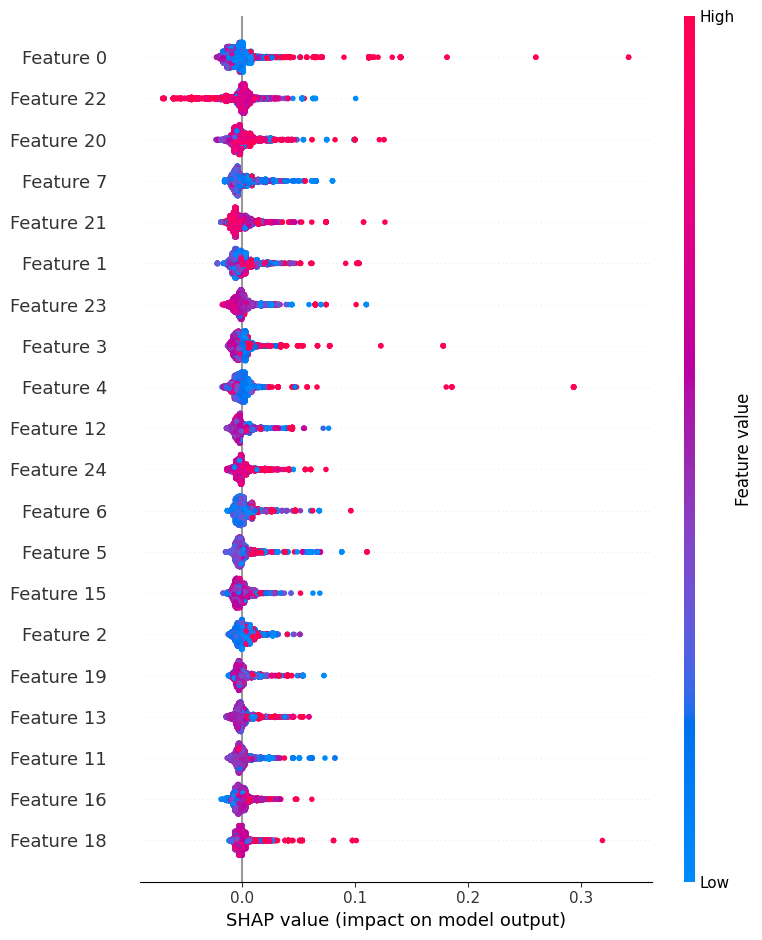

In [14]:
shap.summary_plot(shap_values[1], pca.transform(eX))

0.930898321816387
<class 'shap.explainers._tree.Tree'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


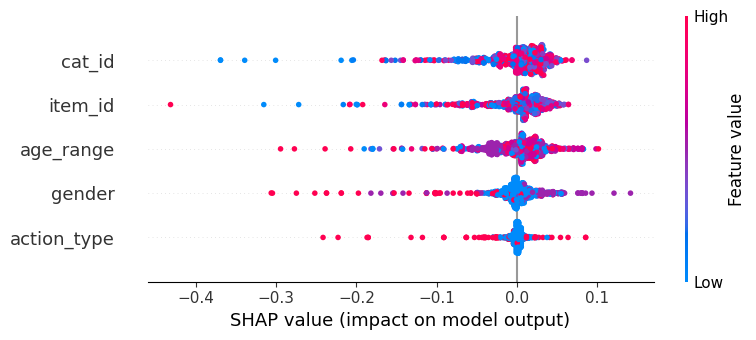

In [19]:
# As we expect, running Shapley analysis on PCA is useless. Let's go back to our original forest
forest = RandomForestClassifier().fit(X_train, y_train)
print(forest.score(X_test, y_test))
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_train.head(1000))
print(type(explainer))
shap.summary_plot(shap_values[0], X_train.head(1000))

In [27]:
# This is more useful, but not nearly as much because we treat cat_id and item_id as non-categorical data.
# You can see this because the feature values don't really follow a pattern
# We can interpret age range, though. It's also a mixed bag, but we can see the center of the mass shifted rightwards, meaning that any age could influence the output more
# We also see the large amount of purple to the left, indicating that middle-aged people are less likely to change the output.
# Gender is tricker as the "low" represents females and the "high" represents males. Females mostly don't influence outputs, but some men can influence output indicated by the purple mass to the right.
# Action type is normal. The "low" represents clicks (a common action) and higher values are better than clicks. Just clicks alone don't suggest anything, but any higher values (such as a person adding to the cart or purchasing it) can signfiicantly influence the results.